In [131]:
import os
from pathlib import Path

if '__setup_done' not in globals():
    os.chdir("..")
    __setup_done = True
    print("디렉토리 변경 완료")
else:
    print("이미 실행됨 - 스킵")

Path.cwd()

이미 실행됨 - 스킵


WindowsPath('d:/02_Projects/Dev/X-ray_AI/Reflecto/runs/exp03_physics_fused')

thicknesses: [58.66140477 53.99532145], roughnesses: [0.40531492 0.56708382], slds: [12.20778397  3.27754163]


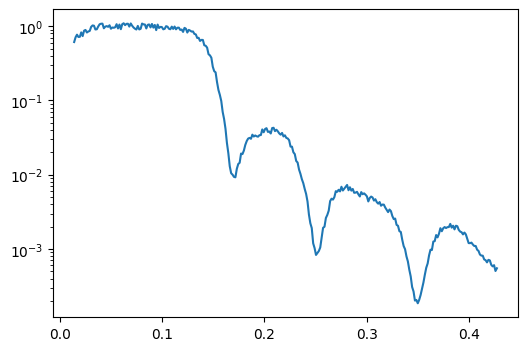

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from model_fused import PhysicsLayer

# from reflecto.simulate.simulator import XRRSimulator, tth2q_wavelen
from reflecto.simulate.simul_genx import XRRSimulator, tth2q_wavelen

wavelen: float = 1.54  # (nm)
tth_min: float = 0.2   # degree
tth_max: float = 6.0
tth_n: int = 300
tths: np.ndarray = np.linspace(tth_min, tth_max, tth_n)
qs: np.ndarray = tth2q_wavelen(tths, wavelen)

xrr_simulator = XRRSimulator(qs, 2, 1)
thicknesses, roughnesses, slds, refl = next(xrr_simulator.make_params_refl())

print(f"thicknesses: {thicknesses}, roughnesses: {roughnesses}, slds: {slds}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(qs, refl)
ax.set_yscale("log")

plt.show()

In [133]:
refl_tensor = torch.tensor(np.log10(refl), dtype=torch.float32).unsqueeze(0)  # (1, Q)
qs_tensor = torch.tensor(qs, dtype=torch.float32)

print("실제 파라미터:")
print(f"두께: {thicknesses} Å")
print(f"거칠기: {roughnesses} Å")
print(f"SLD: {slds} Å^-2")

실제 파라미터:
두께: [58.66140477 53.99532145] Å
거칠기: [0.40531492 0.56708382] Å
SLD: [12.20778397  3.27754163] Å^-2


In [134]:
# 주피터 셀 3: PhysicsLayer 실행
# PhysicsLayer 초기화
physics_layer = PhysicsLayer(qs_tensor, n_layers=2)

# 추정 실행
with torch.no_grad():
    est_thickness, confidence = physics_layer(refl_tensor)

# 결과 출력
print("\nPhysicsLayer 추정 결과:")
print(f"추정 두께: {est_thickness[0].numpy()} Å")
print(f"실제 두께: {thicknesses} Å")
print(f"MAE: {np.mean(np.abs(est_thickness[0].numpy()[:len(thicknesses)] - thicknesses)):.2f} Å")

[ 53  72  99 119]

PhysicsLayer 추정 결과:
추정 두께: [ 79.141335 111.110146] Å
실제 두께: [58.66140477 53.99532145] Å
MAE: 38.80 Å


In [135]:
import numpy as np
import scipy as scp
import scipy.signal as signal
import scipy.signal.windows as fft_windows
from scipy import interpolate
from scipy.signal.windows import flattop, hamming, hann


def xrr_wavelet(x, y, d=None, window=2, n=None, step_num: int = 1000, w=6.0):
    """
    Morlet 기반 Continuous Wavelet Transform(CWT)
    PyWavelets 미사용. SciPy 기반 직접 구현.
    FFT 기반 xrr_fft() 형태와 유사한 출력(xf, yf) 반환.

    Parameters
    ----------
    x, y : 입력 데이터
    d : dx (None이면 등간격 보간 후 자동 산출)
    window : 0=none, 1=hann, 2=hamming, 3=flattop
    n : max scale (None이면 데이터 길이 사용)
    step_num : resampling 포인트 수
    w : Morlet wavelet central frequency

    Returns
    -------
    xf : pseudo-frequency
    yf : CWT power spectrum
    """

    # ----- 1) 등간격 보간 -----
    f_cubic = interpolate.interp1d(x, y, kind="cubic")
    x = np.linspace(x.min(), x.max(), step_num)
    y = f_cubic(x)

    if d is None:
        d = x[1] - x[0]

    N = len(y)

    # ----- 2) 윈도우 처리 -----
    if window == 0:
        w_func = np.ones(N)
    elif window == 1:
        w_func = hann(N)
    elif window == 2:
        w_func = hamming(N)
    else:
        w_func = flattop(N)

    y = y * w_func / np.mean(w_func)

    # ----- 3) 스케일 설정 -----
    if n is None:
        n = N

    # Morlet wavelet scale range
    # 작은 scale = high frequency, 큰 scale = low frequency
    widths = np.linspace(1.0, n / 4, step_num)

    # ----- 4) CWT 직접 계산 -----
    # (FFT 기반 convolution 사용 → 속도/안정성 개선)
    cwtmatr = np.zeros((len(widths), N), dtype=np.complex128)

    for i, width in enumerate(widths):
        # Wavelet 생성
        wavelet = signal.morlet2(M=N, s=width, w=w)

        # FFT convolution 수행
        conv = signal.fftconvolve(y, wavelet, mode="same")
        cwtmatr[i, :] = conv

    # ----- 5) scale → pseudo-frequency 변환 -----
    # 일반적인 Morlet wavelet CWT의 한계 freq 변환식
    #   f ≈ w / (2π * scale * d)
    # 여기서 w는 central frequency
    xf = w / (2 * np.pi * widths * d)

    # ----- 6) power spectrum -----
    # FFT(yf)=평균 스펙트럼과 유사하게 "scale 방향 평균"으로 변환
    yf = np.abs(cwtmatr).mean(axis=1)

    return xf, yf


def xrr_fft(x, y, d=None, window=2, n=None, step_num: int = 1000):
    """
    FFT 변환 (XRR 분석 전용)

    """
    # 등간격 보간
    f_cubic = scp.interpolate.interp1d(x, y, kind="cubic")
    x = np.linspace(x.min(), x.max(), step_num)
    y = f_cubic(x)

    if d is None:
        d = x[1] - x[0]

    N = len(y)
    if window == 0:
        w = np.ones(N)
    elif window == 1:
        w = fft_windows.hann(N)
    elif window == 2:
        w = fft_windows.hamming(N)
    else:
        w = fft_windows.flattop(N)

    if n is None:
        n = N

    yf = 2 / N * np.abs(scp.fftpack.fft(w * y / np.mean(w), n=n))
    xf = scp.fftpack.fftfreq(n, d=d)
    return xf[: n // 2], yf[: n // 2]

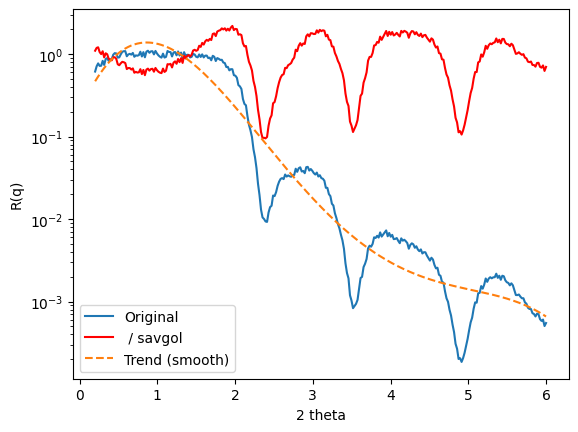

In [136]:
from itertools import combinations_with_replacement

from scipy.signal import argrelmax

# 주피터 셀 4: 신호 처리 과정 시각화 (FFT)
# FFT 계산 (PhysicsLayer 내부 과정)
window_len = len(refl)

R_smooth = signal.savgol_filter(np.log10(refl), window_length=window_len, polyorder=4, mode='interp')
savgol = 10 ** R_smooth
R_savgol = refl / savgol
R_savgol = R_savgol / (R_savgol[0] + 1e-12) * refl.max()
# R_smooth = signal.savgol_filter(np.log10(refl), window_length=window_len, polyorder=4, mode='interp')

plt.figure()
plt.plot(tths, refl, label='Original')
plt.plot(tths, R_savgol, label=' / savgol', color='red')
plt.plot(tths, savgol, label='Trend (smooth)', linestyle='--')
plt.xlabel('2 theta')
plt.ylabel('R(q)')
plt.yscale('log')
plt.legend()
plt.show()

In [137]:
import numpy as np
from scipy import signal


def morlet2_custom(M, s, w=6.0):
    """
    SciPy morlet2 대체 구현 (PyWavelets 정의 기반)
    M : 길이
    s : scale (표준 편차 역할)
    w : central frequency
    """
    # 대칭 중심
    t = np.arange(-(M // 2), M // 2)
    # Morlet wavelet
    wave = np.exp(1j * w * t / s) * np.exp(-(t ** 2) / (2 * s ** 2))
    # L2 normalization
    wave /= np.sqrt(np.sum(np.abs(wave) ** 2))
    return wave


def xrr_wavelet(x, y, d=None, window=2, n=None, step_num: int = 1000, w=6.0):
    """
    PyWavelets 없이 Morlet wavelet 기반 Continuous Wavelet Transform(CWT)
    FFT 기반 xrr_fft()와 동일한 입출력 형식 유지
    """

    # ----- 1) 등간격 보간 -----
    f_cubic = interpolate.interp1d(x, y, kind="cubic")
    x = np.linspace(x.min(), x.max(), step_num)
    y = f_cubic(x)

    if d is None:
        d = x[1] - x[0]

    N = len(y)

    # ----- 2) 윈도우 -----
    if window == 0:
        w_func = np.ones(N)
    elif window == 1:
        w_func = hann(N)
    elif window == 2:
        w_func = hamming(N)
    else:
        w_func = flattop(N)

    y = y * w_func / np.mean(w_func)

    # ----- 3) scale 설정 -----
    if n is None:
        n = N

    widths = np.linspace(1.0, n / 4, step_num)

    # ----- 4) CWT 계산 -----
    cwtmatr = np.zeros((len(widths), N), dtype=np.complex128)

    for i, width in enumerate(widths):
        wavelet = morlet2_custom(M=N, s=width, w=w)
        conv = signal.fftconvolve(y, wavelet, mode='same')
        cwtmatr[i, :] = conv

    # ----- 5) pseudo-frequency -----
    xf = w / (2 * np.pi * widths * d)

    # ----- 6) 파워 스펙트럼 -----
    yf = np.abs(cwtmatr).mean(axis=1)

    return xf, yf


In [138]:
# import pandas as pd
# import matplotlib.pyplot as plt


# file = r"D:\03_Resources\Data\XRR_AI\XRR_data\TMS 150°C 30min NOLE.dat"
# df = pd.read_csv(file, header=None, sep=r"\s+", names=["tth", "R"])
# tths = df["tth"]
# refl = df["R"]
# qs = tth2q_wavelen(tths)
# print(qs.shape, tths.shape)
# fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# ax.plot(tths, refl)
# ax.set_yscale("log")

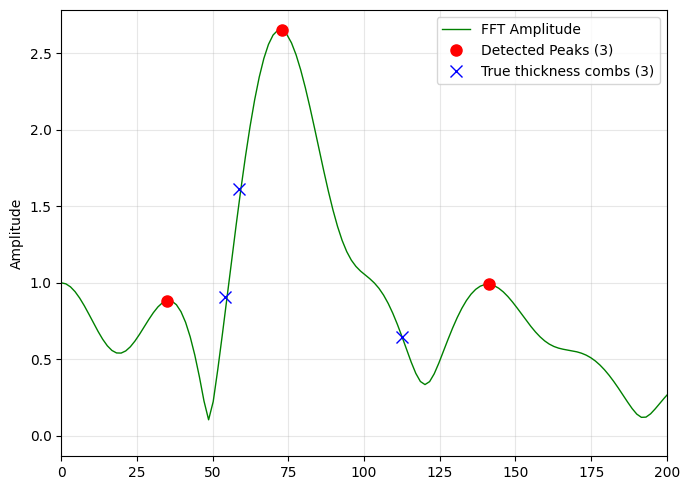

In [139]:
# FFT
xf, yf = xrr_fft(qs, np.log(R_savgol + 0.00001), window=2, n=10000)
x_fft = xf * 2 * np.pi
y_fft = yf / yf[0]
# 피크 검출
x_upper = 200
upper_idx = np.searchsorted(x_fft, 200.0)
detected_peaks = []

peak_indices = argrelmax(y_fft[:upper_idx])[0]
# 플롯
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# FFT 및 피크
ax.plot(x_fft, y_fft, 'g-', linewidth=1, label='FFT Amplitude')
if len(peak_indices) > 0:
    ax.plot(x_fft[peak_indices], y_fft[peak_indices], 'ro', markersize=8, label=f'Detected Peaks ({len(peak_indices)})')

thicknesses_comb = [sum(set(comb)) for comb in combinations_with_replacement(thicknesses, 2)]
thick_comb_idx = [np.argmin(np.abs(x_fft - p)) for p in thicknesses_comb]
ax.plot(thicknesses_comb, y_fft[thick_comb_idx], 'bx', markersize=8, label=f'True thickness combs ({len(thicknesses_comb)})')
ax.set_xlim(0, x_upper)
# ax.set_xlabel('thickness (nm)')
ax.set_ylabel('Amplitude')

ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [140]:
def valid_comb(peaks):
    result = []
    ln = len(peaks)
    for i in range(ln):
        for j in range(i, ln):
            remains = set(range(ln)) - {i, j}
            for k in remains:
                a = peaks[i]
                b = peaks[j]
                c = peaks[k]
                if abs(c - a - b) < 5:
                    result.append([a, b, c])
    return result
valid_combs = valid_comb(x_fft[peak_indices])
print(valid_combs)

[[np.float64(34.97147741079439), np.float64(34.97147741079439), np.float64(72.98395285731004)], [np.float64(72.98395285731004), np.float64(72.98395285731004), np.float64(141.4064086610382)]]
